In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import mibian
import datetime

In [3]:
palette={"deribit_disparity": "#751515", "disparity": "#157540"}

In [4]:
eth = pd.read_csv('../data processing/put call parity/eth_put_call_parity.csv')

In [22]:
print('avergate atm:', eth[eth['atm'] < 1]['strike'].mean())

avergate atm: 3039.509536784741


2024-07-26 36.91% disparity not zero
2024-07-26 70.57% disparity not zero (deribit)

2024-08-30 27.16% disparity not zero
2024-08-30 75.62% disparity not zero (deribit)

2024-09-27 84.15% disparity not zero
2024-09-27 95.08% disparity not zero (deribit)



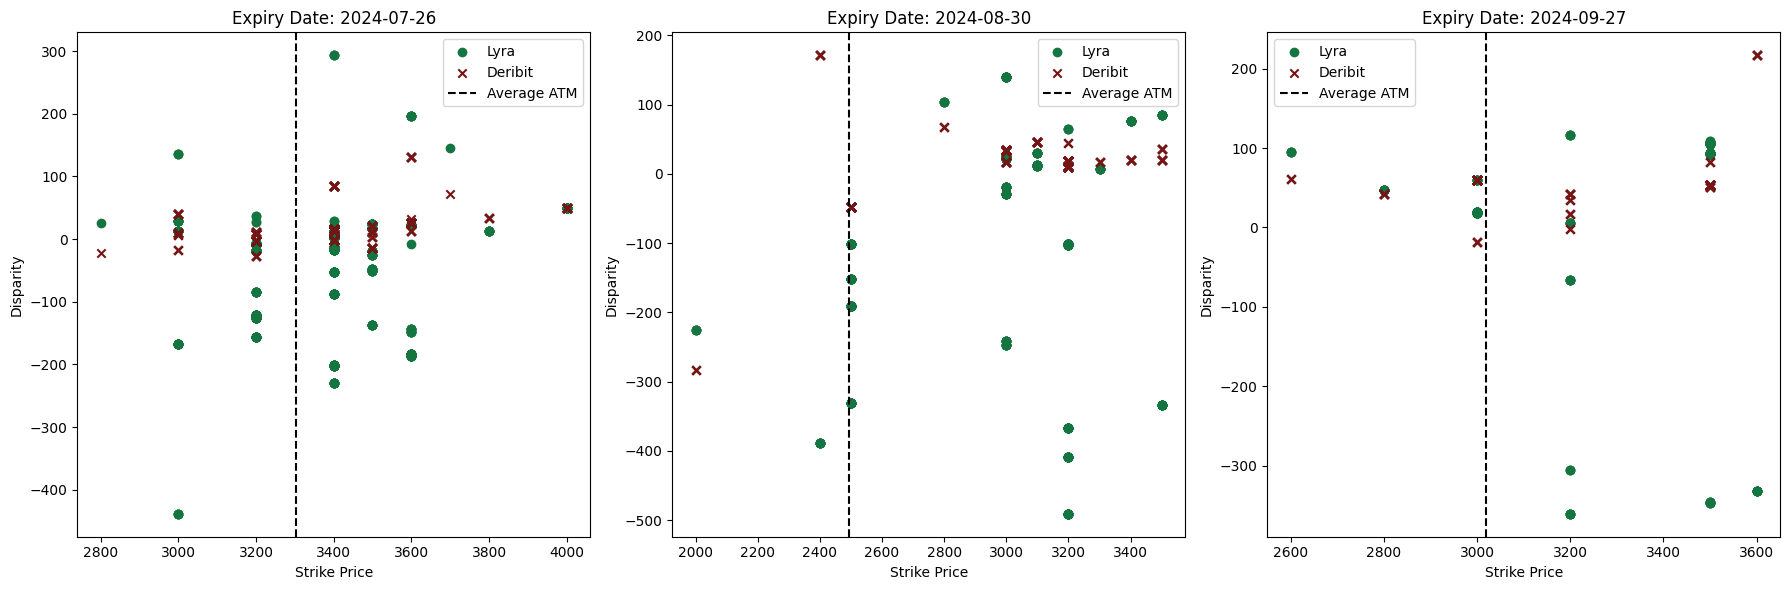

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # One row, three columns
for (expiry, group), ax in zip(eth[eth['expiry'].map(eth['expiry'].value_counts()) > 20].groupby('expiry'), axes.flatten()):
    e = datetime.datetime.strptime(expiry, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d") 
    ax.set_title(f"Expiry Date: {e}")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Disparity")
    
    # Plotting the disparity
    ax.scatter(group['strike'], group['disparity'], marker='o', color=palette['disparity'], label='Lyra')
    ax.scatter(group['strike'], group['deribit_disparity'], marker='x', color=palette['deribit_disparity'], label='Deribit')
    
    # calculate average at-the-money
    average_atm = group[group['strike'] - group['S'] < 1]['strike'].mean()
    ax.axvline(average_atm, color='black', linestyle='--', label='Average ATM')

    ax.legend()

    # print percentage of not zero disparity
    print(f'{e} {len(group[group["disparity"] > 1]) / len(group) * 100:.2f}% disparity not zero')
    print(f'{e} {len(group[group["deribit_disparity"] > 1]) / len(group) * 100:.2f}% disparity not zero (deribit)')
    print()

plt.tight_layout()
plt.savefig('disparities-for-strike-expiries.png')
plt.show()

In [25]:
# calculate price using mibian
def calculate_black_scholes(dataset):
    # Calculate the Mibian price for each option
    dataset['bs_C'] = dataset.apply(lambda x: mibian.BS([x['S'], x['strike'], x['r'], x['T']*365], volatility=x['C_IV']).callPrice, axis=1)
    dataset['bs_P'] = dataset.apply(lambda x: mibian.BS([x['S'], x['strike'], x['r'], x['T']*365], volatility=x['P_IV']).putPrice, axis=1)
    dataset['deribit_bs_C'] = dataset.apply(lambda x: mibian.BS([x['S'], x['strike'], x['r'], x['T']*365], volatility=x['Deribit_C_IV']).callPrice, axis=1)
    dataset['deribit_bs_P'] = dataset.apply(lambda x: mibian.BS([x['S'], x['strike'], x['r'], x['T']*365], volatility=x['Deribit_P_IV']).putPrice, axis=1)
    
    dataset['black_scholes_deribit_disparity'] = (dataset['deribit_bs_C'] - dataset['deribit_bs_P']) - dataset['S-Ke^-rT']
    dataset['black_scholes_disparity'] = (dataset['bs_C'] - dataset['bs_P']) - dataset['S-Ke^-rT']
    return dataset

# calculate price using mibian
eth = calculate_black_scholes(eth)[~eth['bs_P'].isna()]


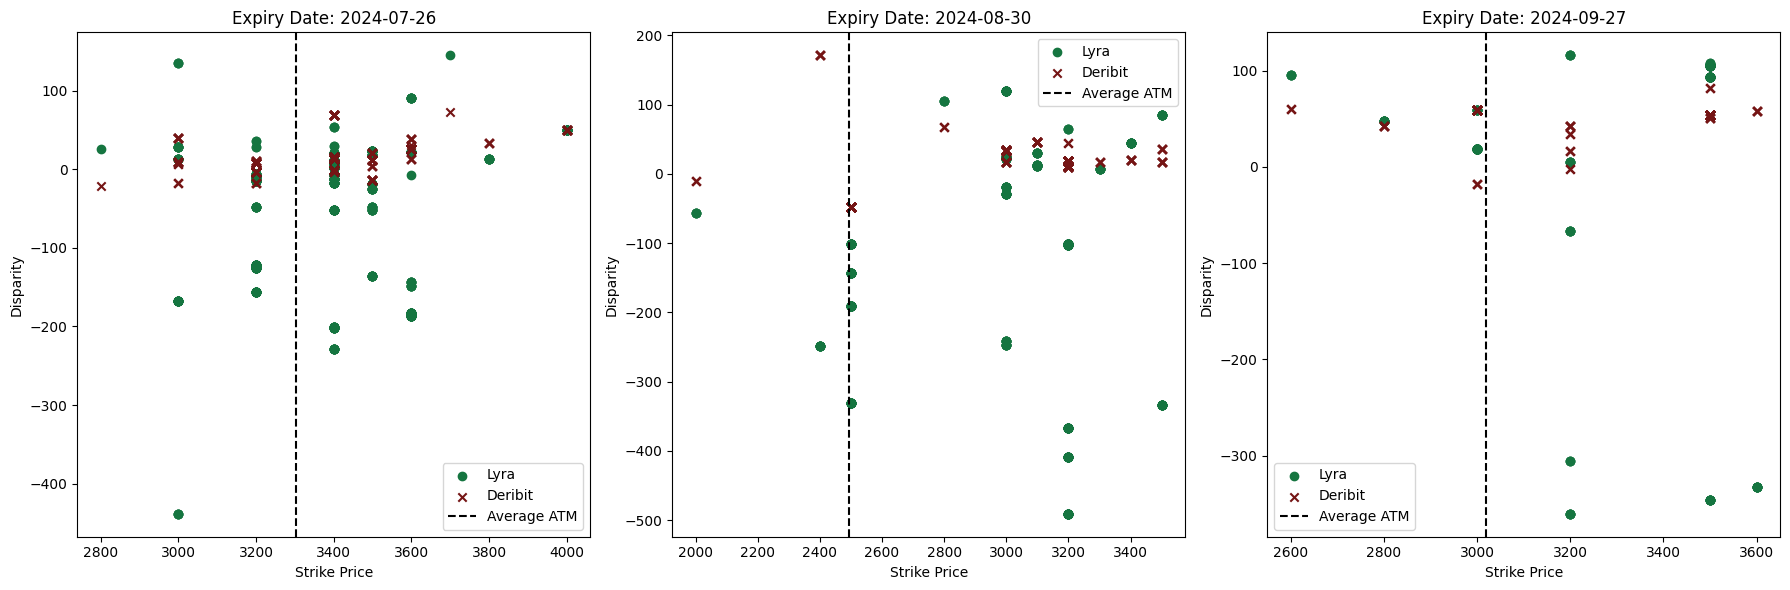

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # One row, three columns
for (expiry, group), ax in zip(eth[eth['expiry'].map(eth['expiry'].value_counts()) > 20].groupby('expiry'), axes.flatten()):
    e = datetime.datetime.strptime(expiry, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d") 
    ax.set_title(f"Expiry Date: {e}")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Disparity")
    
    # Plotting the disparity
    ax.scatter(group['strike'], group['black_scholes_disparity'], marker='o', color=palette['disparity'], label='Lyra')
    ax.scatter(group['strike'], group['black_scholes_deribit_disparity'], marker='x', color=palette['deribit_disparity'], label='Deribit')
    
    # calculate average at-the-money
    average_atm = group[group['strike'] - group['S'] < 1]['strike'].mean()
    ax.axvline(average_atm, color='black', linestyle='--', label='Average ATM')
    
    ax.legend()


plt.tight_layout()
plt.savefig('black-scholes-disparities-for-strike-expiries.png')
plt.show()

In [28]:
eth['disparity_deviation'] = eth['disparity'] - eth['black_scholes_disparity']
eth['deribit_disparity_deviation'] = eth['deribit_disparity'] - eth['black_scholes_deribit_disparity']

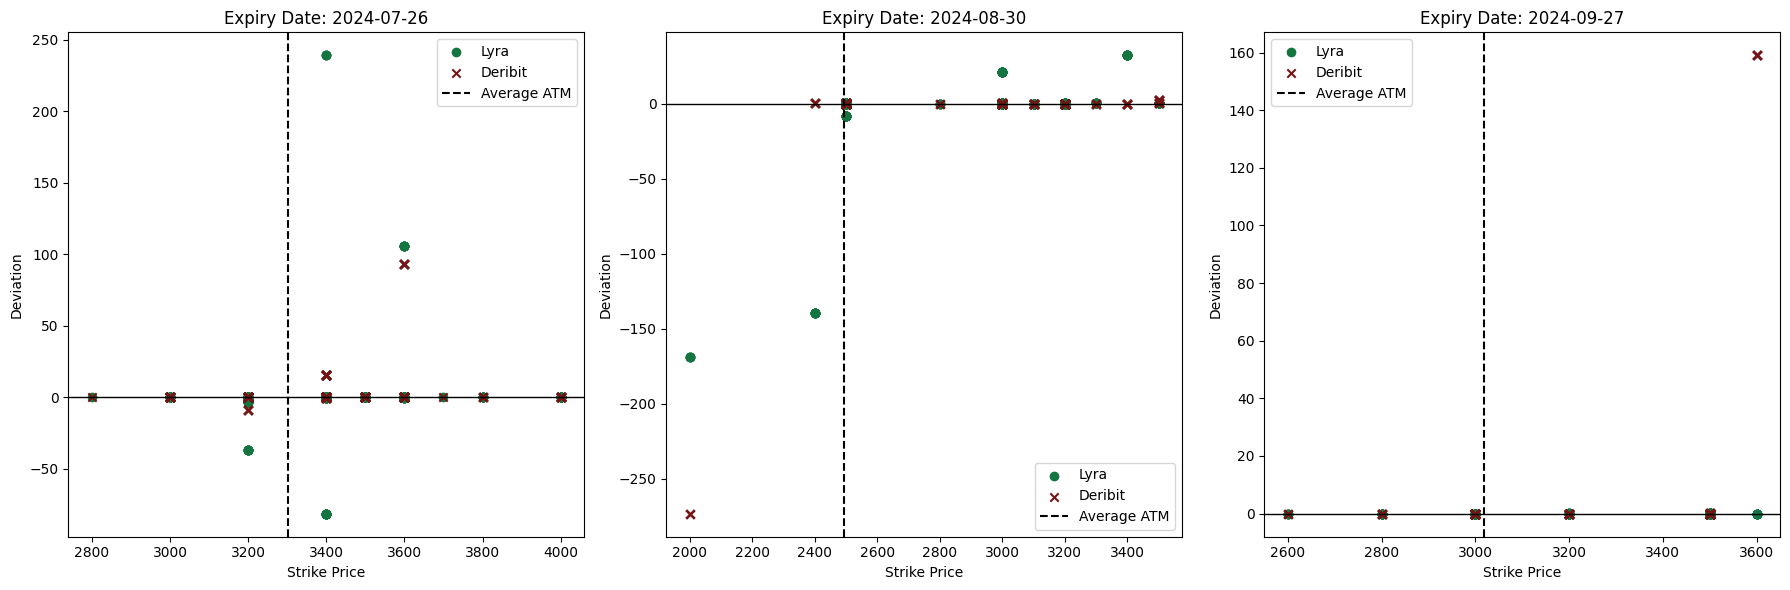

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # One row, three columns
for (expiry, group), ax in zip(eth[eth['expiry'].map(eth['expiry'].value_counts()) > 20].groupby('expiry'), axes.flatten()):
    e = datetime.datetime.strptime(expiry, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d") 
    ax.set_title(f"Expiry Date: {e}")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Deviation")
    
    # Plotting the disparity
    ax.scatter(group['strike'], group['disparity_deviation'], marker='o', color=palette['disparity'], label='Lyra')
    ax.scatter(group['strike'], group['deribit_disparity_deviation'], marker='x', color=palette['deribit_disparity'], label='Deribit')
    
    # calculate average at-the-money
    average_atm = group[group['strike'] - group['S'] < 1]['strike'].mean()
    ax.axvline(average_atm, color='black', linestyle='--', label='Average ATM')
    
    # remove grid
    ax.grid(False)

    # plot horizontal line at 0
    ax.axhline(0, color='black', lw=1)

    ax.legend()


plt.tight_layout()
plt.savefig('deviation-of-disparities.png')
plt.show()

In [34]:
def add_contract_name_column(instruments):
    for i, ins in instruments.iterrows():
        expiration_date = datetime.datetime.strptime(ins['expiry'], "%Y-%m-%d %H:%M:%S").strftime("%m-%d")
        strike_price =  int(ins['strike'])
        formatted_string = f"{expiration_date} {strike_price}"
        instruments.at[i, 'instrument'] = formatted_string

add_contract_name_column(eth)

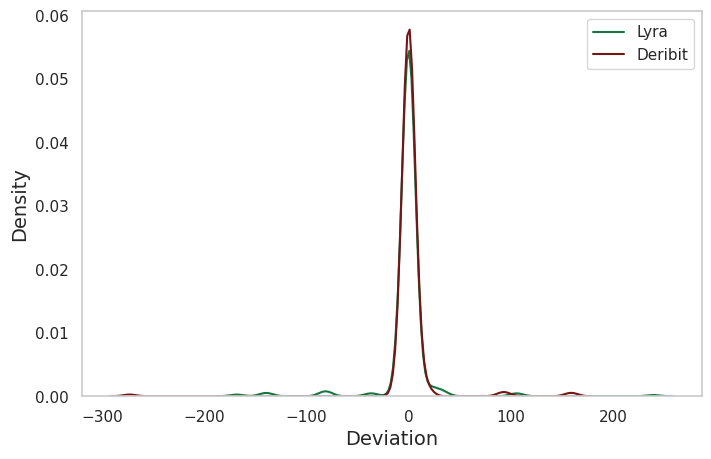

In [112]:
# plot the disparity deviation density distribution
fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(eth['disparity_deviation'], ax=ax, label='Lyra', color=palette['disparity'])
sns.kdeplot(eth['deribit_disparity_deviation'], ax=ax, label='Deribit', color=palette['deribit_disparity'])
ax.set_xlabel('Deviation', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.grid(False)
ax.legend()
plt.show()

40.05742145178765


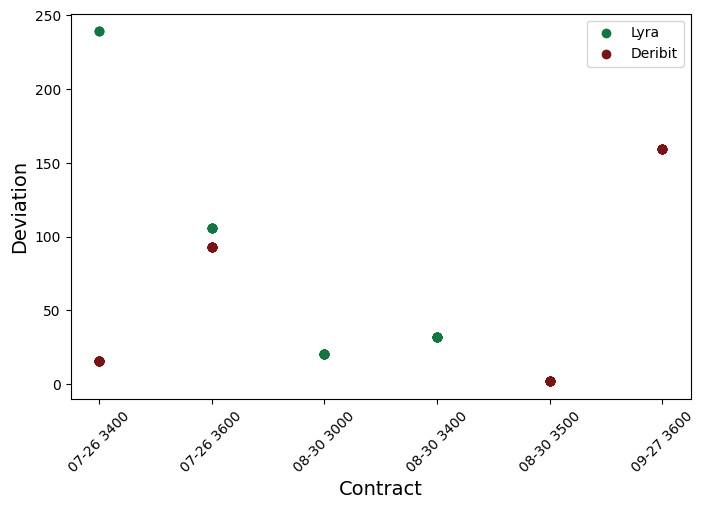

In [35]:
# scatter plot, x axis is contract y axis is disparity deviation
fig, ax = plt.subplots(figsize=(8, 5))

dev = eth[eth['disparity_deviation'] > 0.7]
deribit_dev = eth[eth['deribit_disparity_deviation'] > 0.7]

print(len(dev) + len(deribit_dev) / len(eth))
ax.scatter(dev['instrument'], dev['disparity_deviation'], color=palette['disparity'], label='Lyra')
ax.scatter(deribit_dev['instrument'], deribit_dev['deribit_disparity_deviation'], color=palette['deribit_disparity'], label='Deribit')

ax.set_xlabel('Contract', fontsize=14)
ax.set_ylabel('Deviation', fontsize=14)
ax.legend()
ax.grid(False)
plt.xticks(rotation=45)
plt.show()
